# ALL Analysis

In [1]:
import sys
import os;os.chdir('../')
import itertools as it
import numpy as np
import pandas as pd
import pylab as py
import matplotlib.pyplot as plt
from  matplotlib import rc
from matplotlib.colors import LogNorm
%matplotlib inline
from tools.tools import save,load,lprint,load_config
from tools.bar import BAR
from fitlab.resman import RESMAN
from fitlab.parman import PARMAN
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)

In [2]:
conf=load_config('inputs/sia.py')
conf['resman']=RESMAN(conf)
conf['resman'].get_residuals(conf['parman'].par);

loading sia data sets 1005

## Load Data from Files

In [25]:
ALL=pd.concat([pd.DataFrame(conf['resman'].siares.tabs[idx]) \
              for idx in conf['resman'].siares.tabs.keys()])

ALL.columns

Index([          u'N',           u'Q',          u'Q2',     u'S2/1+C2',
           u'S2/1-C2',       u'Shift',       u'alpha',         u'col',
          u'dS2/1-C2',         u'dqT',         u'dz1',         u'dz2',
               u'obs',          u'pT',       u'pTmax',       u'pTmin',
                u'qT', u'r-residuals',   u'residuals',       u'shift',
            u'stat_u',       u'sys_u',       u'syt_u',         u'thy',
             u'value',          u'z1',       u'z1max',       u'z1min',
                u'z2',       u'z2max',       u'z2min'],
      dtype='object')

## Split Data
Organize data from different collaborations with different observables

In [53]:
data = {}
collaborations = np.unique(ALL.col)

for collab in collaborations:
    data[collab] = {}
    
    data_subset = ALL[ALL.col == collab]
    observables = np.unique(data_subset.obs)
    
    for observable in observables:        
        data[collab][observable] = data_subset[data_subset.obs == observable]        
        print('Collaboration: %s, Observerable: %s, Points: %d' % (collab, observable, len(data[collab][observable])))

Collaboration: BaBaR, Observerable: AUC-0-PT, Points: 9
Collaboration: BaBaR, Observerable: AUC-0-PT-INT, Points: 36
Collaboration: BaBaR, Observerable: AUL-0-PT, Points: 9
Collaboration: BaBaR, Observerable: AUL-0-PT-INT, Points: 36
Collaboration: belle, Observerable: AUC-0-PT-INT, Points: 16
Collaboration: belle, Observerable: AUL-0-PT-INT, Points: 16


## Start Plotting 
Below we plot the data vs. theory curves

In [54]:
plt.rc('font', family='serif')
plt.rc('font', size=16)

In [55]:
# from the paper https://arxiv.org/pdf/1309.5278.pdf
z1_bins = np.array([0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9])

In [130]:
def plot(data):

    n_col = 3
    n_row = len(z1_bins)/n_col + 1

    plt.figure(figsize=(4 *n_col, 3 *n_row))

    for index in range(len(z1_bins)-1):
        data_auc = data['AUC-0-PT-INT'].query('z1 > %f and z1 < %f' % (z1_bins[index], z1_bins[index+1]))
        data_aul = data['AUL-0-PT-INT'].query('z1 > %f and z1 < %f' % (z1_bins[index], z1_bins[index+1]))

        plt.subplot(n_row, n_col, index+1)
        plt.errorbar(data_auc.z2, data_auc.value, data_auc.alpha, 
                    marker='o', linestyle='', color='red', label='$A_{UC}$')
        plt.plot(data_auc.z2, data_auc.thy, linestyle='-', color='red')

        plt.errorbar(data_aul.z2, data_aul.value, data_aul.alpha, 
                    marker='o', linestyle='', color='blue', label='$A_{UL}$')
        plt.plot(data_aul.z2, data_aul.thy, linestyle='-', color='blue')
        plt.xlim([0.0, 1.0])
        plt.xlabel('$Z_2$')
        plt.title('$Z_1 \in [%.1f, %.1f]$' % (z1_bins[index], z1_bins[index+1]))
        
        # the legend has theory labels and I dont like them.
        if len(data_auc) > 0 and len(data_aul) > 0:
            handles, labels = plt.gca().get_legend_handles_labels()
            good_handles = []
            good_labels = []
            for handle, label in zip(handles, labels):
                if 'thy' not in label:
                    good_handles.append(handle)
                    good_labels.append(label)
            
            plt.legend(good_handles, good_labels, frameon=False, loc='topleft')
        
    plt.tight_layout()

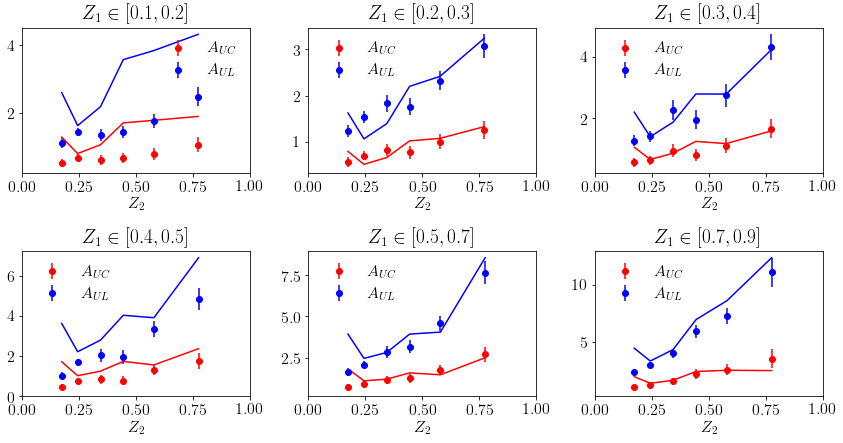

In [133]:
plot(data['BaBaR'])
plt.savefig('sia_babar.pdf')

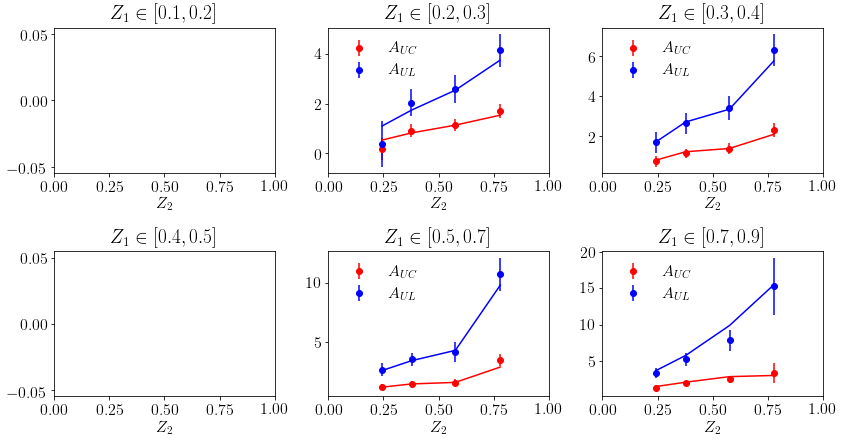

In [134]:
plot(data['belle'])
plt.savefig('sia_belle.pdf')